Importing necessary packages - NumPy, Pandas, Seaborn, Tqdm, Matplotlib, Torch and Sklearn

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

Setting device to cuda if cuda is available, else setting device to cpu

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Loading the train and test data

In [ ]:
train = pd.read_csv('train_50.csv') #train_data_downsampled / train_50
train.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,0,0,1,2,1,0,0,1,1,1,0,1,0,2,0,1,0,0,13,5,5
1,1,0,1,1,4,0,0,0,1,0,1,0,1,0,1,0,0,0,0,9,5,8
2,0,0,1,1,3,0,0,0,1,1,1,0,1,0,4,5,3,0,1,2,6,7
3,0,0,0,1,3,1,0,0,1,1,1,0,1,0,2,0,2,0,1,9,5,2
4,1,0,0,1,2,0,1,0,1,0,1,0,1,0,5,0,30,1,1,10,6,5


In [ ]:
test = pd.read_csv('test_50.csv') #test_BMI_processed/test_50
test.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,0,1,3,1,0,0,1,1,1,0,1,0,3,5,15,0,1,13,4,6
1,1,0,0,1,4,0,0,0,1,0,1,0,1,0,2,0,0,0,0,13,4,5
2,0,1,1,1,3,0,1,1,1,1,1,0,1,0,4,0,1,1,1,9,4,3
3,0,0,0,1,5,1,0,0,1,0,1,0,1,0,2,0,0,0,1,7,6,8
4,0,1,1,1,2,0,0,0,1,1,1,0,1,1,5,30,30,0,0,10,6,5


In [ ]:
#train['Diabetes_012'].replace(2, 1, inplace=True)
#test['Diabetes_012'].replace(2, 1, inplace=True)

Visualising the distribution of class labels in the training and testing data

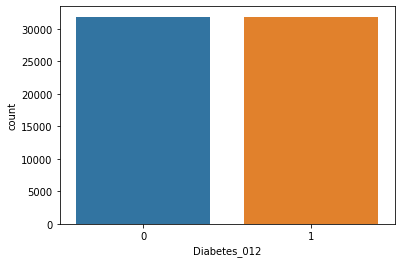

In [ ]:
sns.countplot(x = 'Diabetes_012', data=train)

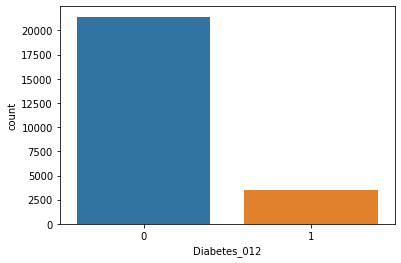

In [ ]:
sns.countplot(x = 'Diabetes_012', data=test)

Splitting the train and test data into X and y 

In [ ]:
X = train.iloc[:, 1:]
y = train.iloc[:, 0]

In [ ]:
X_test = test.iloc[:,1:]
y_test = test.iloc[:,0]

Splitting the X and y obtained from training data into trainning and validation sets

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=32)

Converting X_train, y_train, x_val, y_val, X_test and y_test into numpy arrays for passing to the class ClassifierDataset to generate datasets

In [ ]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [ ]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

Hyperparameter tuning - number of epochs, batch_size, learning_rate

In [ ]:
epochs = 30
batch_size = 50
learning_rate = 0.00006
num_features = len(X.columns)
num_classes = len(set(y))

Initializing dataloader for train, val and test data

In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
)
val_loader = DataLoader(dataset=val_dataset, batch_size= 1) #len(X_val)
test_loader = DataLoader(dataset=test_dataset, batch_size=1) #len(X_test)

Architectures tried for neural network - 

Arch1 - 12,8,6

Arch2 - 16,8,4

Arch3 - 32,16,4

Best performance was observed for Arch 2 - 16,8,4

Defining the architecture of our neural net

In [ ]:
class Net(nn.Module):
    def __init__(self, num_features, num_classes):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(num_features, 16)
        self.fc2 = nn.Linear(16, 8 )
        self.fc3 = nn.Linear(8, 4)
        self.fc4 = nn.Linear(4, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        
        out = self.fc2(out)
        out = self.relu(out)
        
        out = self.fc3(out)
        out = self.relu(out)
        
        out = self.fc4(out)

        return out
        

Creating an instance of the model according to the designed architecture

In [ ]:
model = Net(num_features = num_features, num_classes = num_classes)
print(model)

Net(
  (fc1): Linear(in_features=21, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=4, bias=True)
  (fc4): Linear(in_features=4, out_features=2, bias=True)
  (relu): ReLU()
)


In [ ]:
model.to(device)

Net(
  (fc1): Linear(in_features=21, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=4, bias=True)
  (fc4): Linear(in_features=4, out_features=2, bias=True)
  (relu): ReLU()
)

Defining the loss function and the optimizer to be used for training the neural network

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def calculate_accuracy(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = 0
    for i in range(len(y_test)):
      if y_pred_tags[i] == y_test[i]:
        correct_pred += 1
    acc = correct_pred / len(y_pred)
    acc = acc * 100
    return acc

In [ ]:
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
cal_acc_list = []
train_loader_len = len(train_loader)
val_loader_len = len(val_loader)

for e in tqdm(range(1, epochs+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model.forward(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = calculate_accuracy(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc
  
    with torch.no_grad():
      val_epoch_loss = 0
      val_epoch_acc = 0
      model.eval()
      for X_val_batch, y_val_batch in val_loader:
        X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
        
        y_val_pred = model.forward(X_val_batch)
                    
        val_loss = criterion(y_val_pred, y_val_batch)
        val_acc = calculate_accuracy(y_val_pred, y_val_batch)
        
        val_epoch_loss += val_loss.item()
        val_epoch_acc += val_acc
        
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')
    #print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}')

    train_loss_list.append(train_epoch_loss/train_loader_len)
    train_acc_list.append(train_epoch_acc/train_loader_len)
    val_loss_list.append(val_epoch_loss/val_loader_len)
    val_acc_list.append(val_epoch_acc/val_loader_len)
 


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.67812 | Val Loss: 0.65376 | Train Acc: 55.186| Val Acc: 62.194
Epoch 002: | Train Loss: 0.62471 | Val Loss: 0.60050 | Train Acc: 66.792| Val Acc: 68.597
Epoch 003: | Train Loss: 0.57856 | Val Loss: 0.57157 | Train Acc: 69.806| Val Acc: 70.135
Epoch 004: | Train Loss: 0.55717 | Val Loss: 0.55787 | Train Acc: 71.337| Val Acc: 71.155
Epoch 005: | Train Loss: 0.54596 | Val Loss: 0.54948 | Train Acc: 72.273| Val Acc: 71.955
Epoch 006: | Train Loss: 0.53877 | Val Loss: 0.54350 | Train Acc: 72.829| Val Acc: 72.567
Epoch 007: | Train Loss: 0.53350 | Val Loss: 0.53877 | Train Acc: 73.289| Val Acc: 72.866
Epoch 008: | Train Loss: 0.52953 | Val Loss: 0.53525 | Train Acc: 73.590| Val Acc: 73.117
Epoch 009: | Train Loss: 0.52652 | Val Loss: 0.53256 | Train Acc: 73.706| Val Acc: 73.336
Epoch 010: | Train Loss: 0.52422 | Val Loss: 0.53055 | Train Acc: 73.921| Val Acc: 73.462
Epoch 011: | Train Loss: 0.52226 | Val Loss: 0.52910 | Train Acc: 74.045| Val Acc: 73.478
Epoch 012:

Plot train and validation loss vs. number of epochs

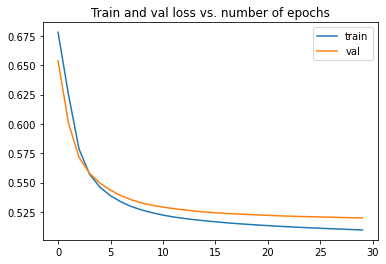

In [ ]:
plt.title("Train and val loss vs. number of epochs")
plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.legend(['train','val'])
plt.show()


Save the model and model weights

In [ ]:
torch.save(model, "model.pth")
torch.save(model.state_dict(), "model_weights.pth")

Plot the train and validation accuracy vs. number of epochs

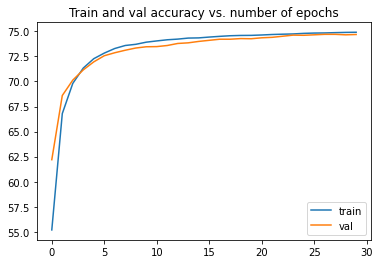

In [ ]:
plt.title("Train and val accuracy vs. number of epochs")
plt.plot(train_acc_list)
plt.plot(val_acc_list)
plt.legend(['train','val'])
plt.show()

Performing prediction on test dataset, visualizing the results with the help of confusion matrix and printing out the classification report

In [ ]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model.forward(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

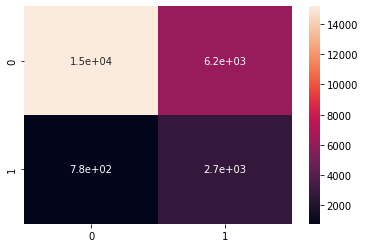

In [ ]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns={0:0,1:1,2:2}, index={0:0,1:1,2:2})

sns.heatmap(confusion_matrix_df, annot=True)

In [ ]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.95      0.71      0.81     21409
           1       0.30      0.78      0.43      3486

    accuracy                           0.72     24895
   macro avg       0.63      0.74      0.62     24895
weighted avg       0.86      0.72      0.76     24895



In [ ]:
print("Precision is: ", precision_score(y_test, y_pred_list, average = 'weighted'))
print("Recall is: ", recall_score(y_test, y_pred_list, average = 'weighted'))
print("F1 Score is: ", f1_score(y_test, y_pred_list, average = 'weighted'))

Precision is:  0.8600835315441946
Recall is:  0.7178951596706166
F1 Score is:  0.7592224502791487
